## **Problem Statement**

Given historic sales data, forecast department-wise weekly sales for 45 Walmart stores located in different regions.




In [5]:
#data analysis libraries
import pandas as pd
import numpy as np

#visualization libraries

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
from scipy.stats import pearsonr

# Set the default figure size for Seaborn plots globally
sns.set(rc={'figure.figsize':(10,6)})
%matplotlib inline 

In [9]:
# Read the data

features_df = pd.read_csv('/Users/gopi.gadu/Downloads/Forecasting_Sales/Forecasting_Walmart_weekly_sales/walmart-recruiting-store-sales-forecasting/features.csv')
stores_df = pd.read_csv('/Users/gopi.gadu/Downloads/Forecasting_Sales/Forecasting_Walmart_weekly_sales/walmart-recruiting-store-sales-forecasting/stores.csv')
train_df = pd.read_csv('/Users/gopi.gadu/Downloads/Forecasting_Sales/Forecasting_Walmart_weekly_sales/walmart-recruiting-store-sales-forecasting/train.csv')
test_df = pd.read_csv('/Users/gopi.gadu/Downloads/Forecasting_Sales/Forecasting_Walmart_weekly_sales/walmart-recruiting-store-sales-forecasting/test.csv')


### Train data 

This is the historical training data, which has data from 2010-02-05 to 2012-11-01. It has the following fields:

- Store -the store number (1 to 45)
- Dept - department number, numbered 1 to 99. All stores don't have every department 
- Date - Date corresponding to Thursday of each week
- Weekly_Sales - Sales for the given department in the given store 
- IsHoliday - whether the week is a special holiday week

In [11]:
train_df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


- There are no null values in the dataset.

In [13]:
train_df.describe()


,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


- There are 45 stores in each with department in it.
- Our target variable Weekly_Sales, is the sales for the week reported on Thursdays of the week.
- There are negative values and clearly outliers in the sales column

### Test Data

This dataset has the same fields as that of the train dataset except for the weekly sales which is our target variable to predict.

In [14]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


- There are no null values in the test set
- We have to predict the weekly sales for a period of 39 weeks (from 2012-11-02 to 2013-07-26)

### **Stores data**

This dataset contains anonymized information about the 45 stores, indicating the type and size of store.

In [16]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [17]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB




### Features Data

This dataset contains additional information related to stores, departments, and regional activity for the given dates. Below are the fields included in the dataset:

- **Store**: The store number.
- **Date**: The date representing each week.
- **Temperature**: The average temperature in the region.
- **Fuel_Price**: The cost of fuel in the region.
- **MarkDown1-5**: Anonymized data related to promotional markdowns that Walmart is running.  
  - MarkDown data is only available after **November 2011** and is not available for all stores at all times.  
  - Missing values are marked as **NA**.
- **CPI**: The Consumer Price Index.
- **Unemployment**: The unemployment rate.
- **IsHoliday**: Indicates whether the week is a special holiday week.

---

### Holidays

For convenience, the dataset includes the following holidays (not all holidays are present in the data):

- **Super Bowl**:  
  - 12-Feb-2010  
  - 11-Feb-2011  
  - 10-Feb-2012  
  - 8-Feb-2013  

- **Labor Day**:  
  - 10-Sep-2010  
  - 9-Sep-2011  
  - 7-Sep-2012  
  - 6-Sep-2013  

- **Thanksgiving**:  
  - 26-Nov-2010  
  - 25-Nov-2011  
  - 23-Nov-2012  
  - 29-Nov-2013  

- **Christmas**:  
  - 31-Dec-2010  
  - 30-Dec-2011  
  - 28-Dec-2012  
  - 27-Dec-2013  


### What is CPI?

The Consumer Price Index measures the overall change in consumer prices based on a representative basket of goods and services over time.  
A CPI of 120 means that prices are 20% higher than in the base year.

### What is the unemployment rate?

The unemployment rate is the percentage of people in the labour force who are unemployed.

In [18]:
features_df.head()



,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [19]:
features_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


- There are missing values in Markdown columns, CPI and unemployment columns

In [20]:
## Analysing data of a single store

features_df[features_df['Store']==1]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
177,1,2013-06-28,83.94,3.495,4205.98,796.70,6.84,3816.78,4812.74,NaN,NaN,False
178,1,2013-07-05,79.85,3.422,7649.99,3503.29,1766.77,9454.96,1079.89,NaN,NaN,False
179,1,2013-07-12,83.12,3.400,6089.94,1362.42,209.62,2367.42,2651.05,NaN,NaN,False
180,1,2013-07-19,79.26,3.556,3117.04,1060.39,199.05,1012.30,5381.72,NaN,NaN,False


- For each store, we have 182 weeks information from Febraury 2012 to July 2013

In [21]:
features_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


## Analysing the distribution of each independent variable

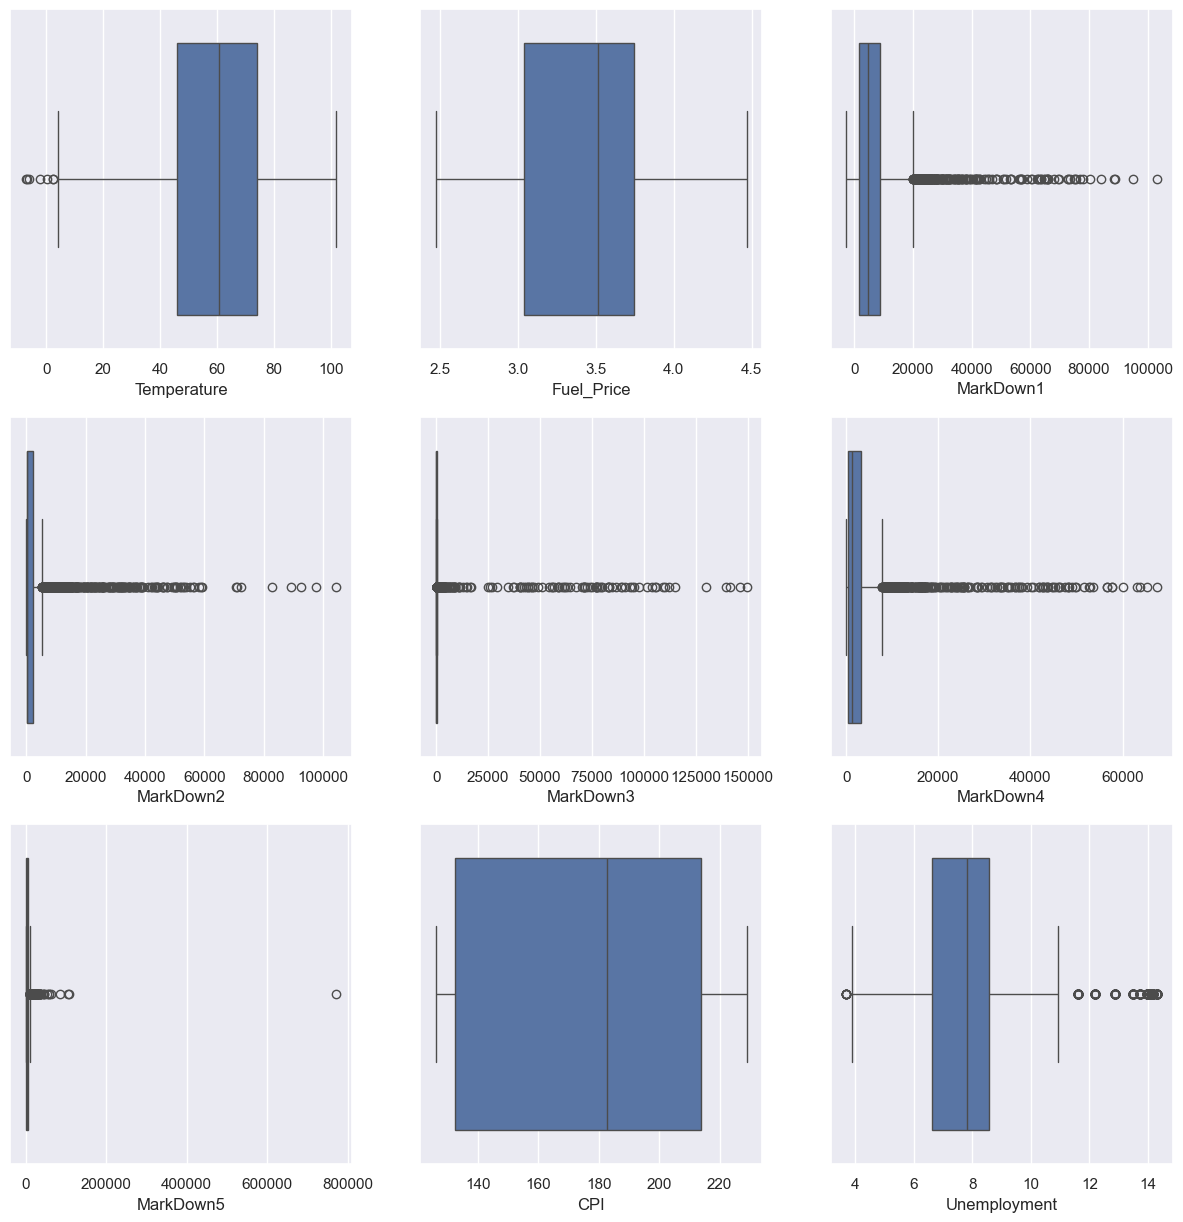

In [22]:
columns = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

fig, axes = plt.subplots(3,3, figsize=(15, 15))

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.boxplot(x= features_df[column], ax=axes[row][col])